In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
tf.config.list_physical_devices('GPU')
import plotly.io as pio
import os
import shutil
import plotly.graph_objs as go
from ipywidgets import Output, VBox
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense,Flatten
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt

TensorFlow version: 2.12.0


# Clear Coat

In [2]:
df_csv = pd.read_csv('2023_10_17_icps_product_id_404_run_id_794_experiment_id_1_to_12.csv', skiprows = 7)

df_csv = df_csv.rename(columns={'Product ID [  ]': 'product_id', 'Run ID [  ]': 'run_id', 'Experiment ID [  ]': 'experiment_id',
                    'Trial ID [  ]': 'trial_id', 'x-Position [ m ]': 'x_position', 'x-Force [ N ]': 'x_force'
                    , 'y-Force [ N ]': 'y_force', 'z-Force [ N ]': 'z_force'})
df_csv1 = df_csv[df_csv["product_id"] == 404]
df_csv1 = df_csv[df_csv["run_id"] == 794]

df_csv2 = df_csv[df_csv["product_id"] == 404]
df_csv2 = df_csv[df_csv["run_id"] == 795]
df_csv2["run_id"] = 794
df_csv2["experiment_id"] = 4
df_csv = pd.concat([df_csv1, df_csv2])

peak_dfs = []
for run_id in df_csv["run_id"].unique():
    keys = dict()
    df_temp2 = df_csv[df_csv["run_id"] == run_id]
    
    for experiment_id in df_temp2["experiment_id"].unique():
        df_temp3 = df_temp2[df_temp2["experiment_id"] == experiment_id]
        
        for trial_id in df_temp3["trial_id"].unique():
            df_temp4 = df_temp3[df_temp3["trial_id"] == trial_id]
            
            if len(df_temp4) > 1:
                peak_dfs.append(df_temp4[["run_id", "experiment_id", "trial_id", 'x_position', 'x_force', 'y_force', 'z_force']])            
print("1", len(peak_dfs))
filtered_peak_dfs = []
for i, item in enumerate(peak_dfs):
    flipped_df = item[::-1]
    filtered_df_temp = flipped_df[flipped_df['x_position'] > 20.0001].reset_index(drop=True)
    
    if len(filtered_df_temp) > 0:
        
        peak_row_temp = filtered_df_temp['x_position'].idxmax()
        
        peak_row_data_temp = filtered_df_temp.loc[:peak_row_temp-1]
        
        filtered_df_temp2 = filtered_df_temp.loc[peak_row_temp:]
        filtered_df_temp2 = filtered_df_temp2[::-1]
        condition = filtered_df_temp2['x_force'] >= 0
        
        extracted_rows = filtered_df_temp2.loc[:condition.idxmax()]
        
        if (extracted_rows['x_position'] >= 99.9).all():
            filtered_peak_dfs1.append(pd.concat([peak_row_data_temp, extracted_rows]))
        else:
            filtered_peak_dfs.append(peak_row_data_temp)  
        #filtered_peak_dfs.append(filtered_df_temp2)    
print("2", len(filtered_peak_dfs))


max_length = max(len(df) for df in filtered_peak_dfs)
print(max_length)
for idx, df in enumerate(filtered_peak_dfs):
    if len(df) == max_length:
        max_df_id = idx
        break
max_length_df = filtered_peak_dfs[max_df_id]
print("max df id", max_df_id)

padded_dataframes = []
for df in filtered_peak_dfs:
    padding_size = 519 - len(df) #padding_size - len(df) # check classification
    if padding_size >= 0:
        try:
            padded_df = pd.DataFrame(np.pad(df.values, ((0, padding_size), (0, 0)), mode='edge'), columns=df.columns)
        except:
            pass
        padded_df['index'] = padded_df.index
    else:
        padded_df = df.sample(n=519, random_state=42).sort_index()
    padded_dataframes.append(padded_df.reset_index(drop=True))

<ipython-input-2-18ab76961137>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv2["run_id"] = 794
<ipython-input-2-18ab76961137>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv2["experiment_id"] = 4


1 120
2 120
555
max df id 68


12
519


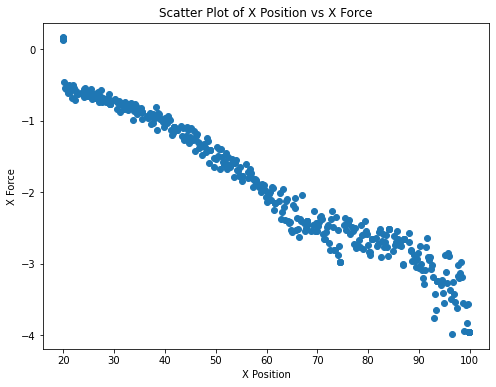

In [3]:
random_number = random.randint(0, len(padded_dataframes) - 1)  # assuming padded_dataframes is a list or a compatible data structure
print(random_number)
df_show = padded_dataframes[random_number]
print(len(df_show))

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(df_show["x_position"], df_show["x_force"])
plt.xlabel('X Position')
plt.ylabel('X Force')
plt.title('Scatter Plot of X Position vs X Force')
plt.show()

# Classification

In [4]:
X= []

for i,item in enumerate(padded_dataframes):
    Peak_df = item
    run_id = Peak_df["run_id"].unique()[0],
    trial_id = Peak_df["trial_id"].unique()[0],
    experiment_id = Peak_df["experiment_id"].unique()[0]
    X.append(Peak_df)
    
print(len(padded_dataframes))
print(len(X))

120
120


In [5]:
tensor_X = []
for item in X:
    item = item[['x_force', 'run_id', 'experiment_id', 'trial_id']].copy()
    a = item.to_numpy().astype(np.float32)
    tensor_X.append(a)

In [6]:
classification_model = tf.keras.models.load_model('./Polke_only_Classification_best_model.h5')
tensor_X_arr = np.array(tensor_X)
print(tensor_X_arr.shape)
print(tensor_X_arr[:, :, 0].shape)
y_pred = classification_model.predict(tensor_X_arr[:, :, 0])

(120, 519, 4)
(120, 519)
4/4 [==============================] - 1s 42ms/step


In [7]:
# Apply threshold of 0.5 to classify into positive and negative classes
threshold = 0.5
y_pred_classes = (y_pred > threshold).astype(int)

# Get indices of positive and negative predictions
positive_indices = np.where(y_pred_classes == 1)[0]
negative_indices = np.where(y_pred_classes == 0)[0]

# Print or use the indices as needed
print("Positive Indices:", positive_indices)
print("Negative Indices:", negative_indices)
print("Length Positive Indices:", len(positive_indices))
print("Length Negative Indices:", len(negative_indices))

Positive Indices: [ 10  20  21  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119]
Negative Indices: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 22 23 24 25 26
 27 28 29]
Length Positive Indices: 93
Length Negative Indices: 27


86
519


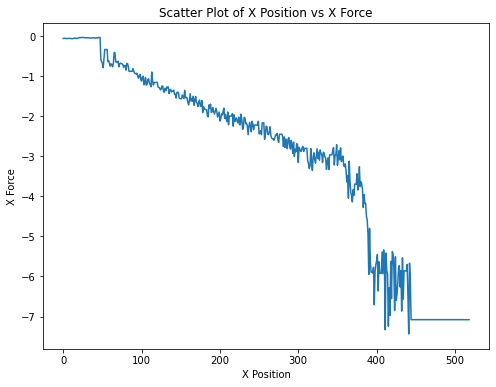

In [8]:
# Extract positive examples from tensor_X
positive_examples = tensor_X_arr[:, :, 0][positive_indices]
positive_ids = tensor_X_arr[:, :, 1:][positive_indices]
random_number = random.randint(0, len(positive_examples) - 1)  # assuming padded_dataframes is a list or a compatible data structure
print(random_number)
df_show = positive_examples[random_number]
print(len(df_show))

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(np.arange(len(df_show)), df_show, label='x-force')
plt.xlabel('X Position')
plt.ylabel('X Force')
plt.title('Scatter Plot of X Position vs X Force')
plt.show()

In [9]:
negative_ids = tensor_X_arr[:, :, 1:][negative_indices]
negative_ids[:, 0, :]

array([[794.,  12.,   9.],
       [794.,  12.,   8.],
       [794.,  12.,   7.],
       [794.,  12.,   6.],
       [794.,  12.,   5.],
       [794.,  12.,   4.],
       [794.,  12.,   3.],
       [794.,  12.,   2.],
       [794.,  12.,   1.],
       [794.,  12.,   0.],
       [794.,  11.,   8.],
       [794.,  11.,   7.],
       [794.,  11.,   6.],
       [794.,  11.,   5.],
       [794.,  11.,   4.],
       [794.,  11.,   3.],
       [794.,  11.,   2.],
       [794.,  11.,   1.],
       [794.,  11.,   0.],
       [794.,  10.,   7.],
       [794.,  10.,   6.],
       [794.,  10.,   5.],
       [794.,  10.,   4.],
       [794.,  10.,   3.],
       [794.,  10.,   2.],
       [794.,  10.,   1.],
       [794.,  10.,   0.]], dtype=float32)

# Regression

In [10]:
regression_model = tf.keras.models.load_model('Polke_only_Regression_best_model.h5')

In [11]:
# Predict
preds = regression_model.predict(np.array(positive_examples))

3/3 [==============================] - 0s 45ms/step


RUN_ID: 794.0, EXP_ID: 11.0, TRIAL_ID: 9.0


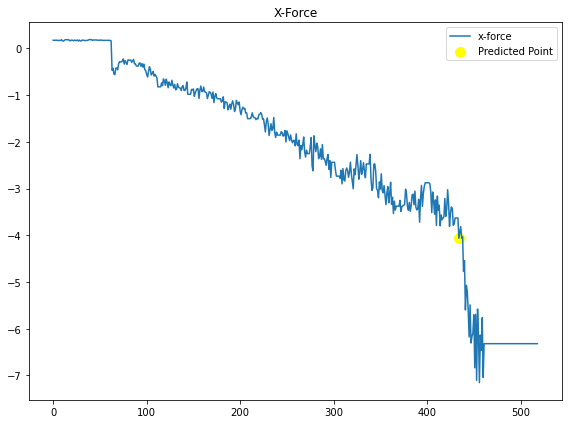

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 10.0, TRIAL_ID: 9.0


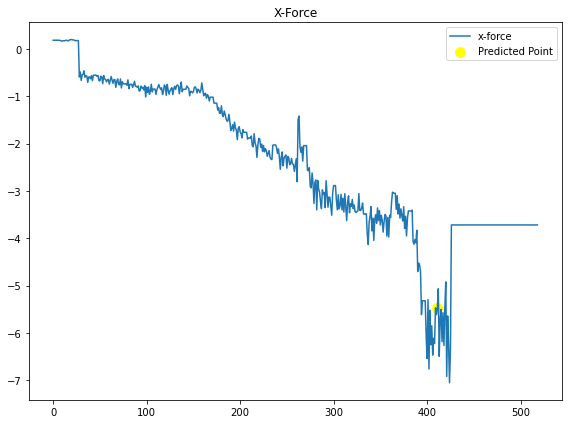

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 10.0, TRIAL_ID: 8.0


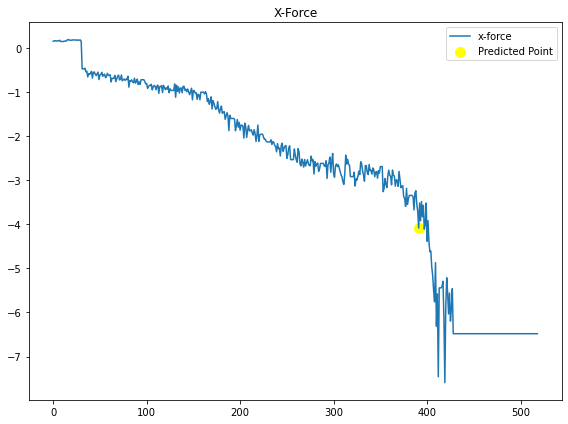

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 9.0, TRIAL_ID: 9.0


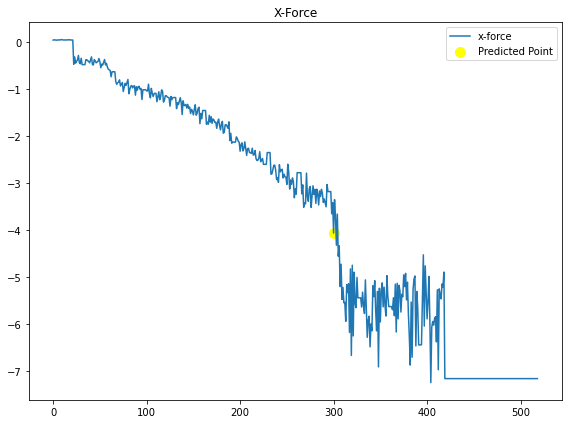

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 9.0, TRIAL_ID: 8.0


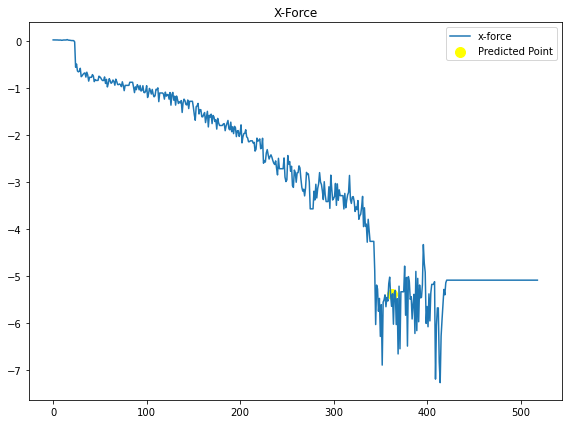

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 9.0, TRIAL_ID: 7.0


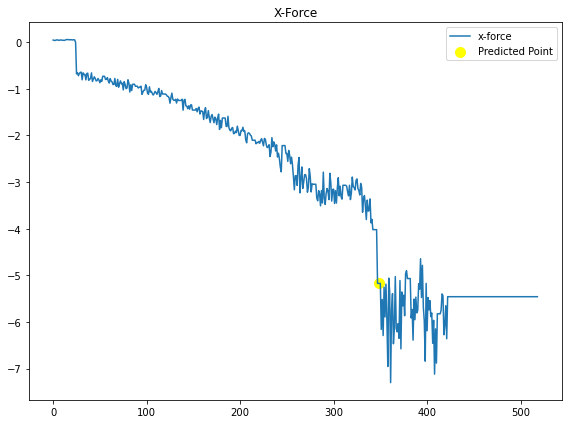

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 9.0, TRIAL_ID: 6.0


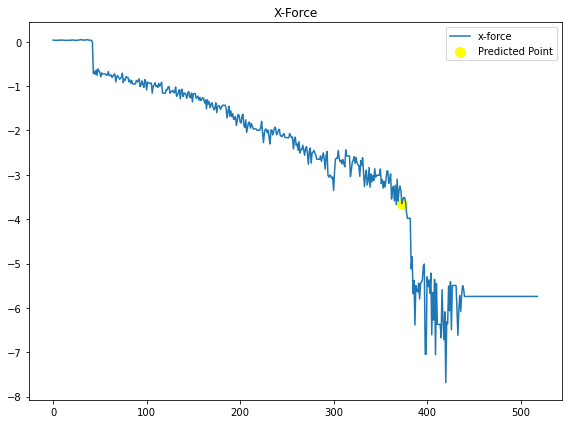

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 9.0, TRIAL_ID: 5.0


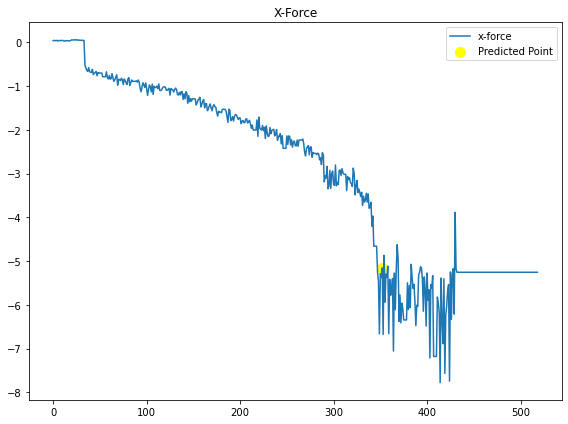

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 9.0, TRIAL_ID: 4.0


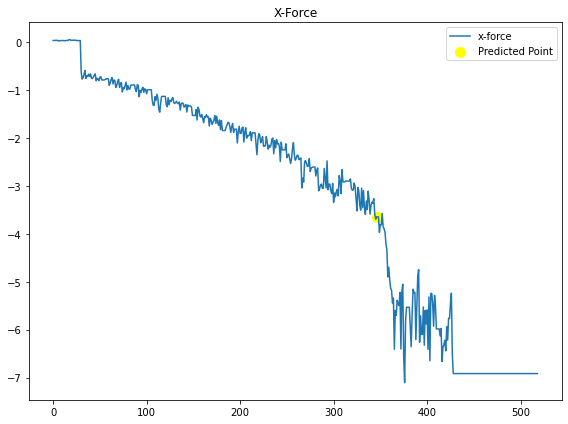

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 9.0, TRIAL_ID: 3.0


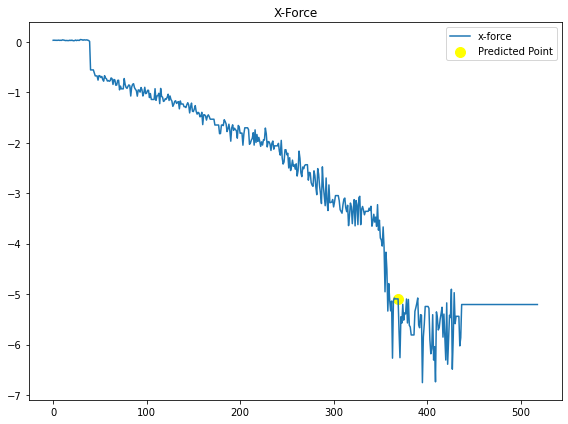

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 9.0, TRIAL_ID: 2.0


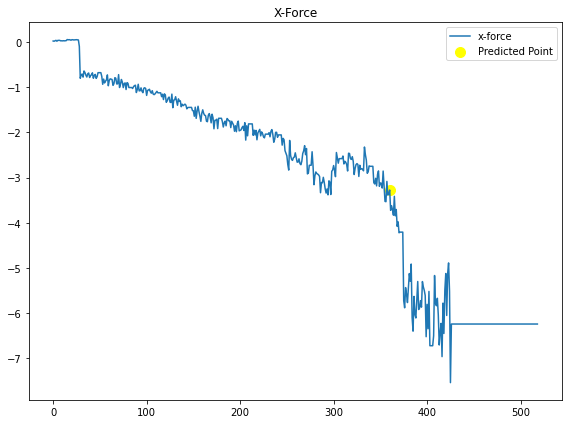

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 9.0, TRIAL_ID: 1.0


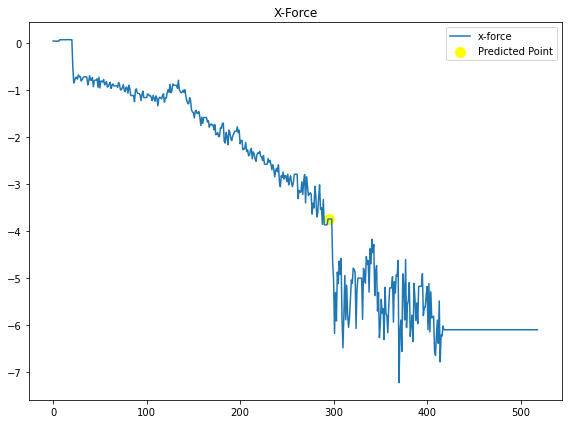

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 9.0, TRIAL_ID: 0.0


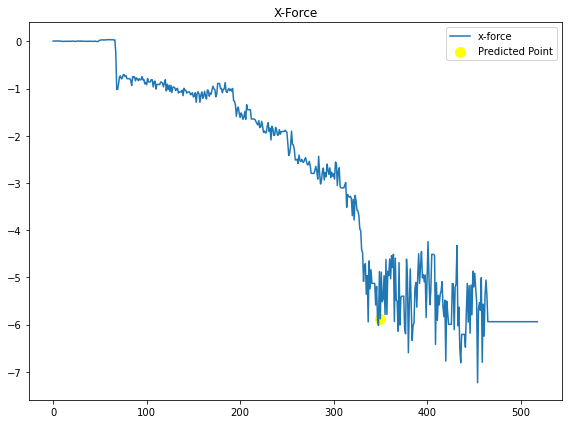

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 8.0, TRIAL_ID: 9.0


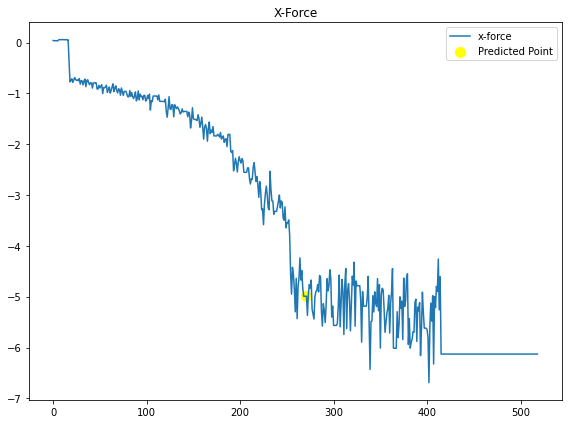

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 8.0, TRIAL_ID: 8.0


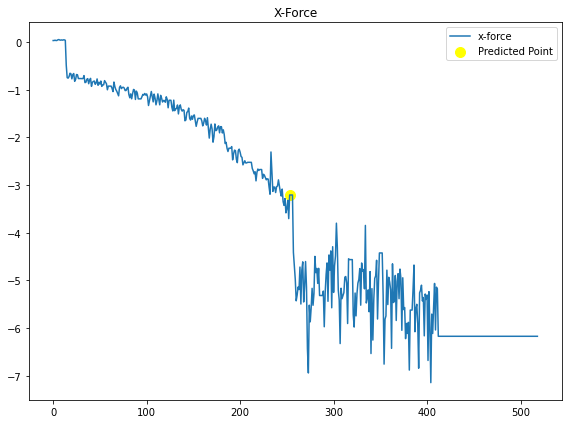

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 8.0, TRIAL_ID: 7.0


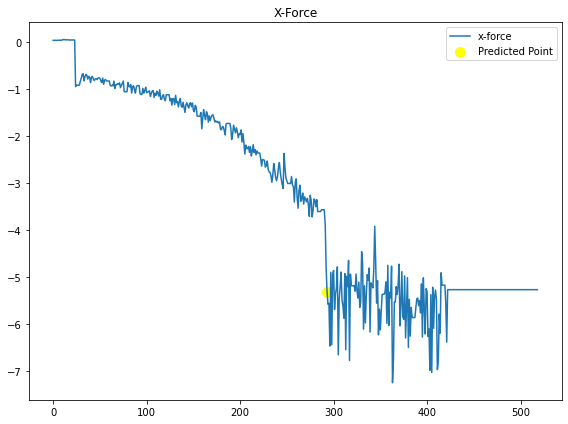

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 8.0, TRIAL_ID: 6.0


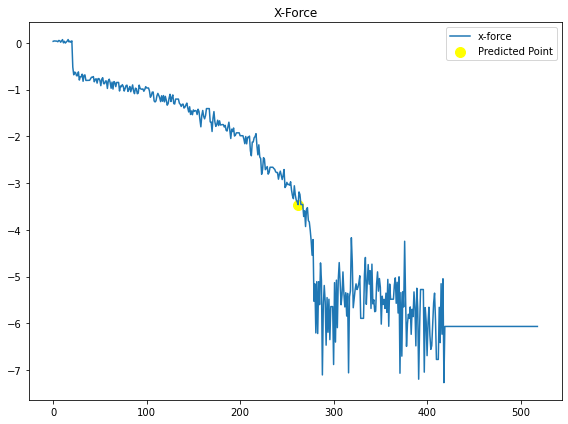

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 8.0, TRIAL_ID: 5.0


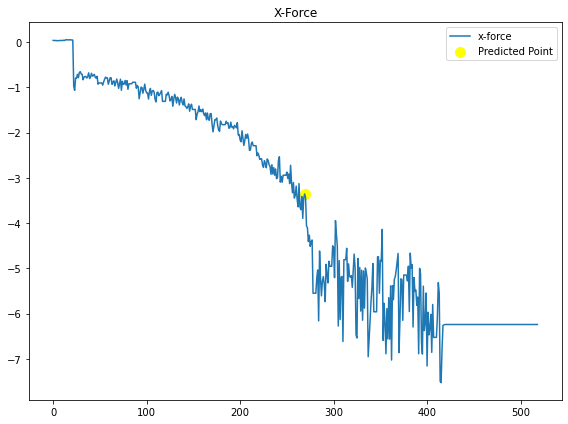

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 8.0, TRIAL_ID: 4.0


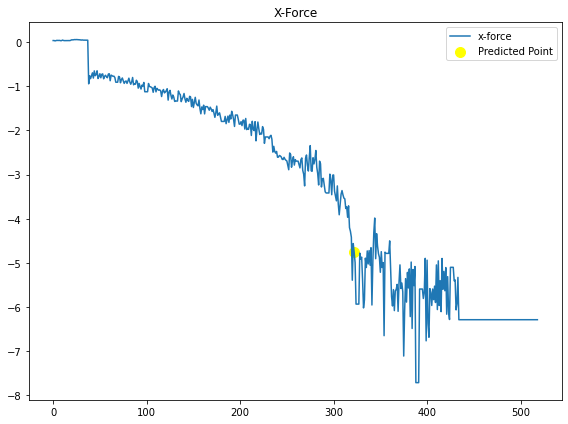

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 8.0, TRIAL_ID: 3.0


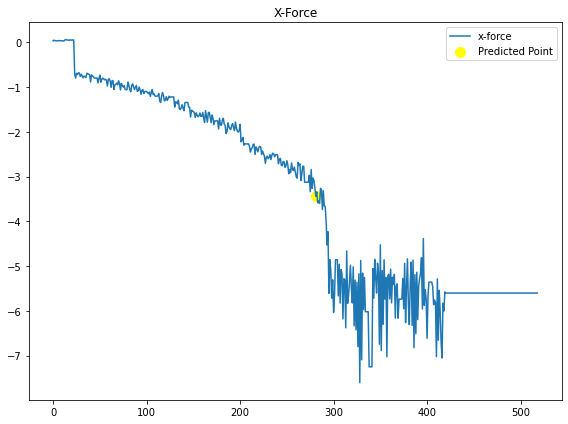

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 8.0, TRIAL_ID: 2.0


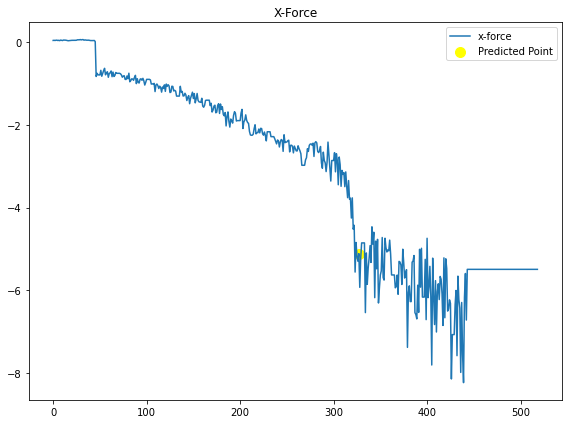

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 8.0, TRIAL_ID: 1.0


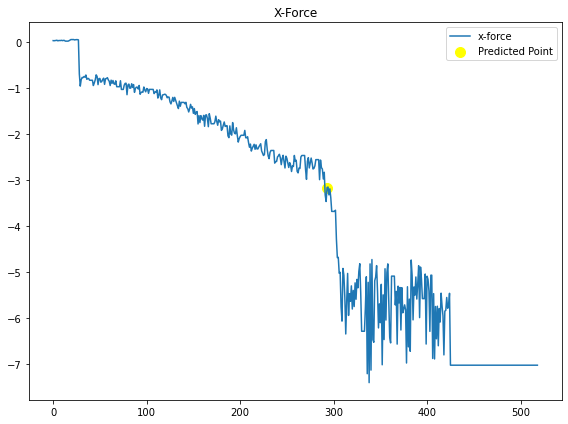

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 8.0, TRIAL_ID: 0.0


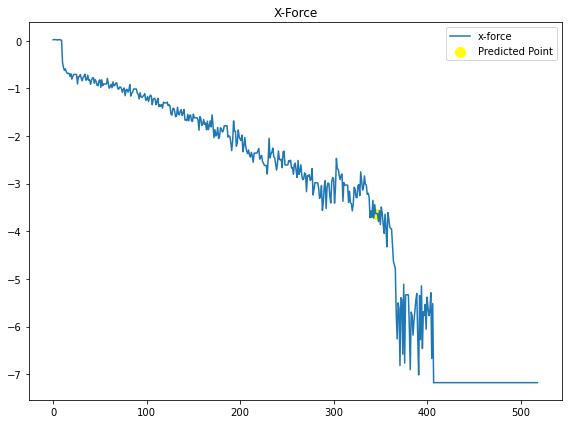

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 7.0, TRIAL_ID: 9.0


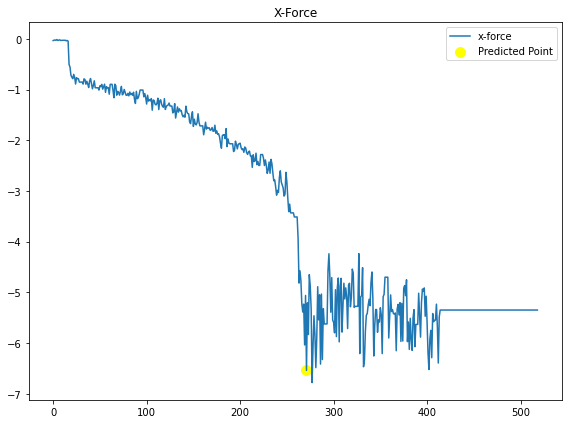

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 7.0, TRIAL_ID: 8.0


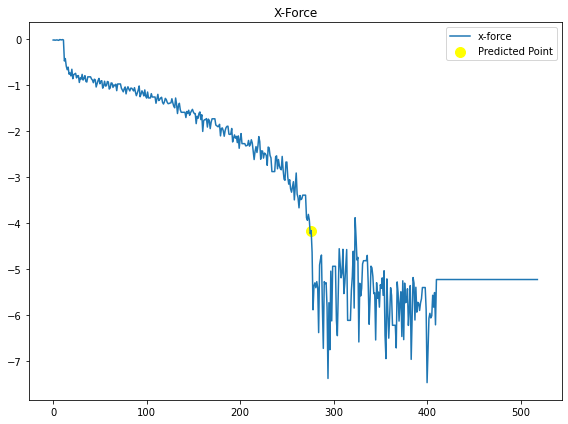

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 7.0, TRIAL_ID: 7.0


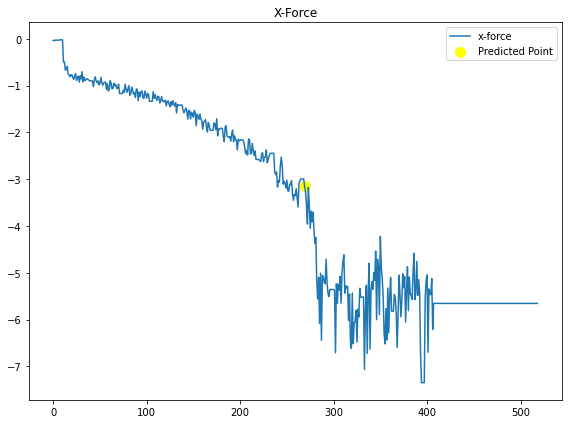

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 7.0, TRIAL_ID: 6.0


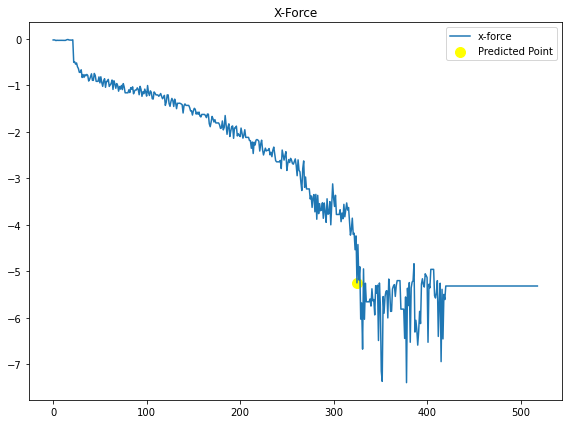

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 7.0, TRIAL_ID: 5.0


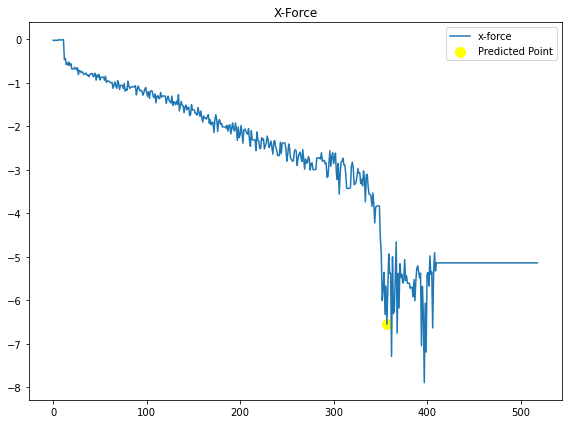

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 7.0, TRIAL_ID: 4.0


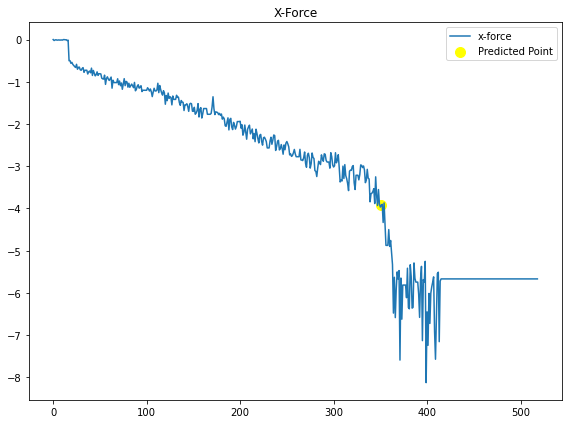

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 7.0, TRIAL_ID: 3.0


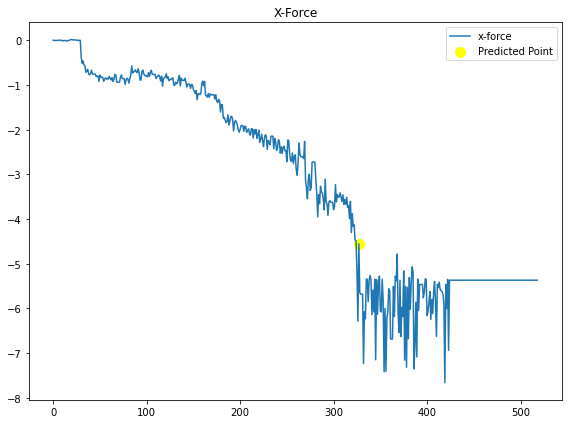

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 7.0, TRIAL_ID: 2.0


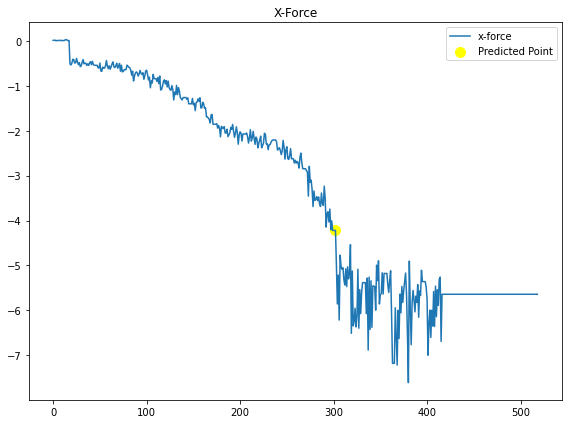

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 7.0, TRIAL_ID: 1.0


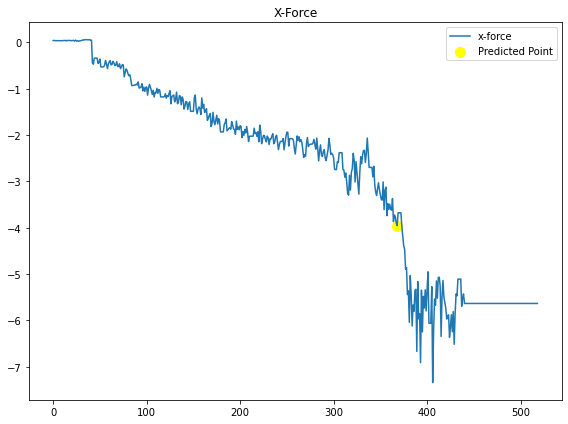

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 7.0, TRIAL_ID: 0.0


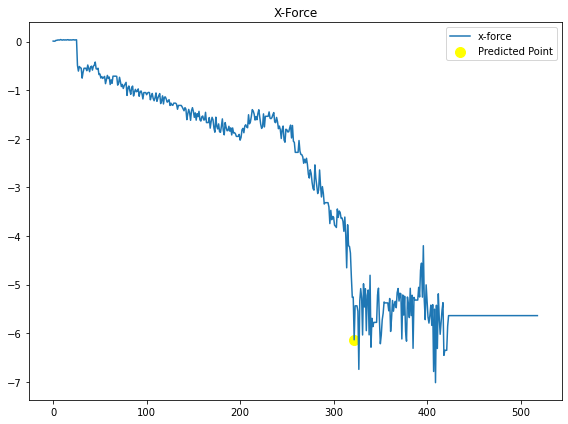

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 6.0, TRIAL_ID: 9.0


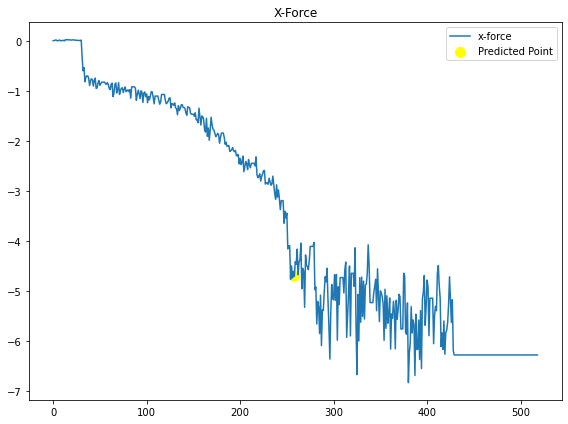

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 6.0, TRIAL_ID: 8.0


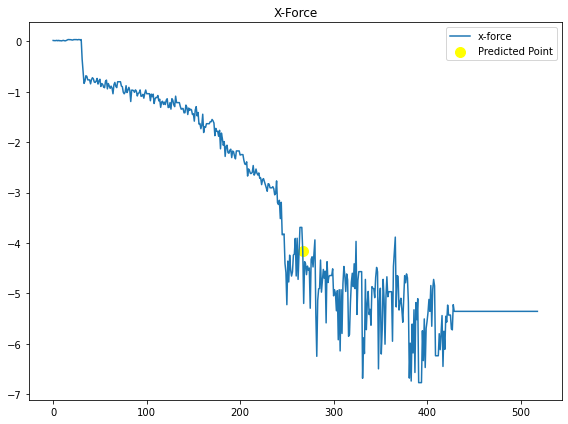

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 6.0, TRIAL_ID: 7.0


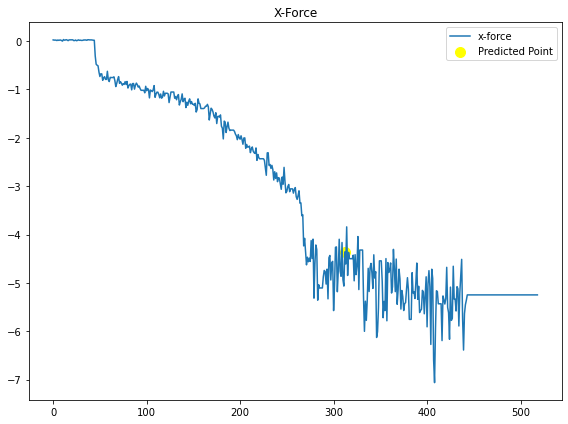

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 6.0, TRIAL_ID: 6.0


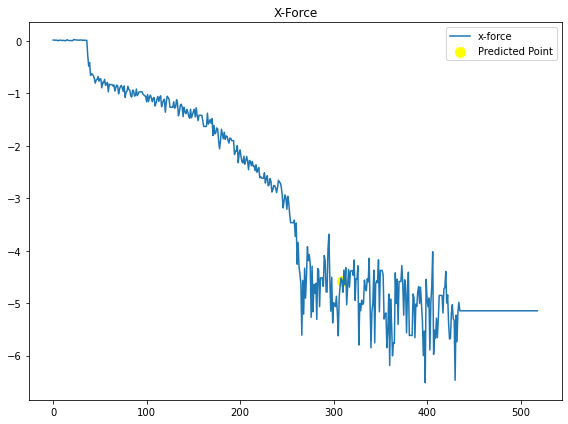

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 6.0, TRIAL_ID: 5.0


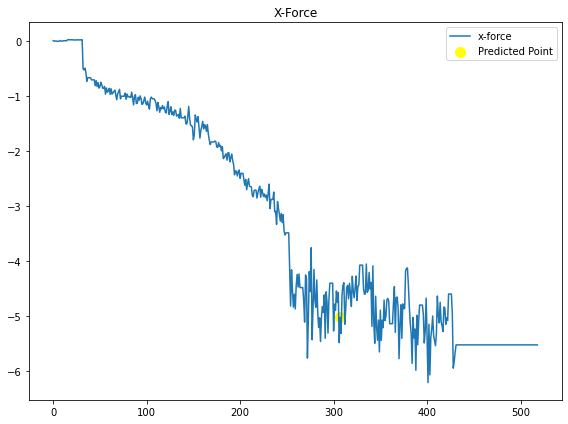

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 6.0, TRIAL_ID: 4.0


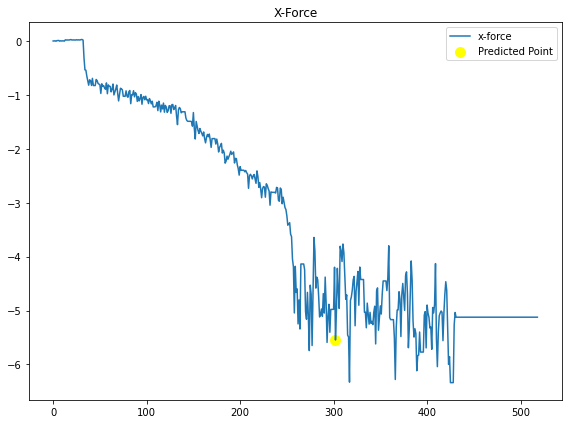

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 6.0, TRIAL_ID: 3.0


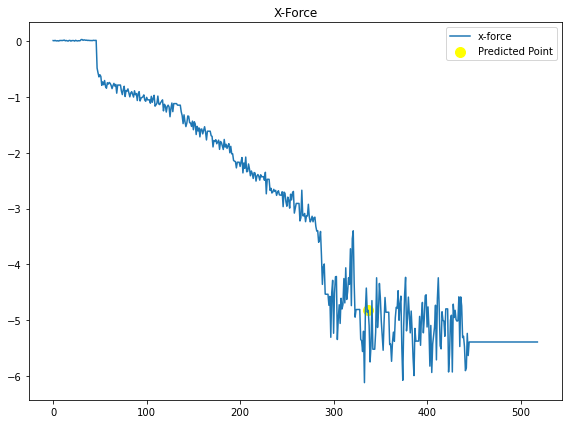

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 6.0, TRIAL_ID: 2.0


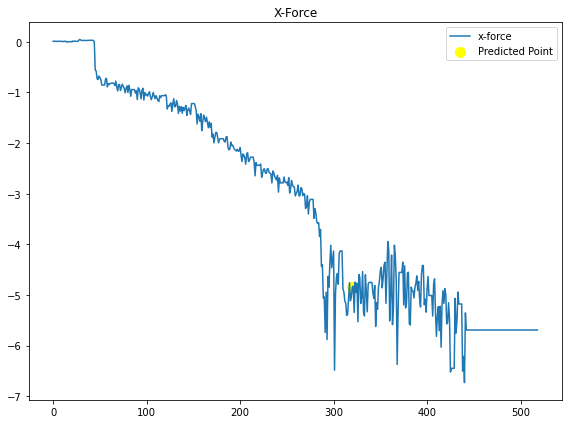

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 6.0, TRIAL_ID: 1.0


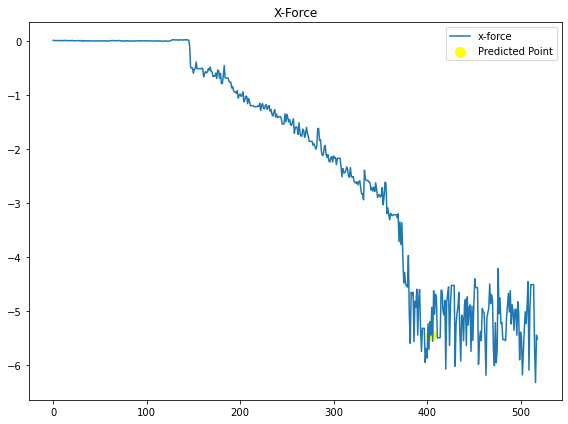

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 6.0, TRIAL_ID: 0.0


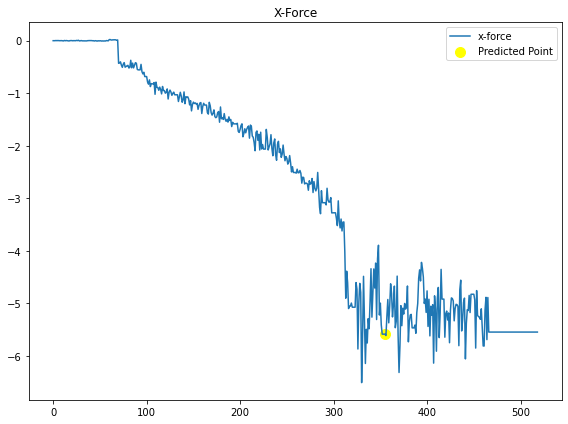

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 5.0, TRIAL_ID: 9.0


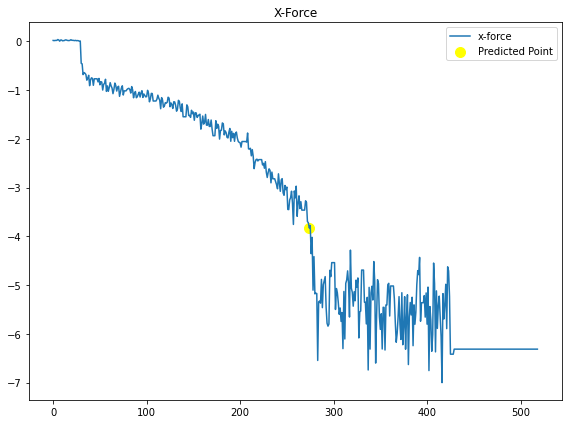

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 5.0, TRIAL_ID: 8.0


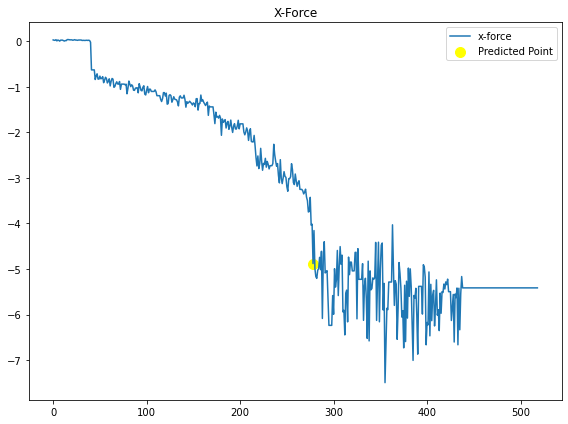

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 5.0, TRIAL_ID: 7.0


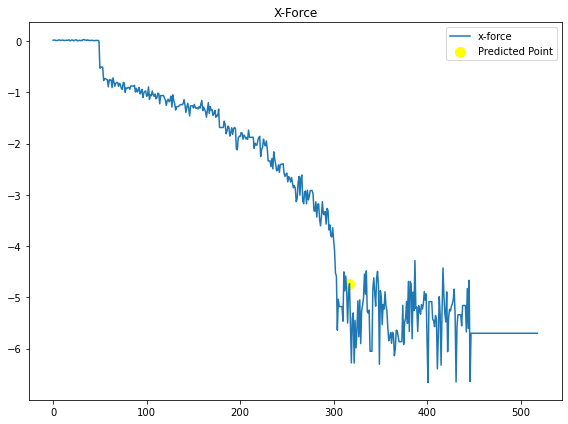

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 5.0, TRIAL_ID: 6.0


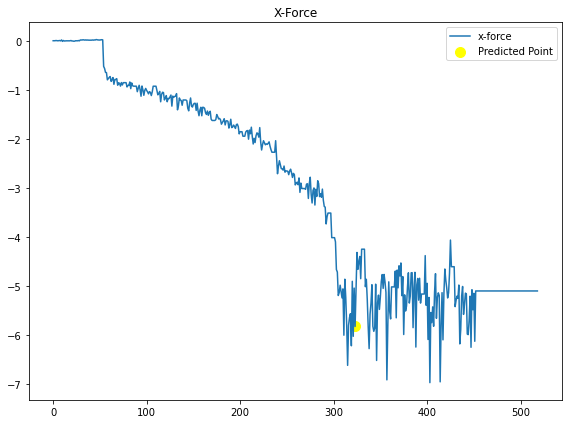

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 5.0, TRIAL_ID: 5.0


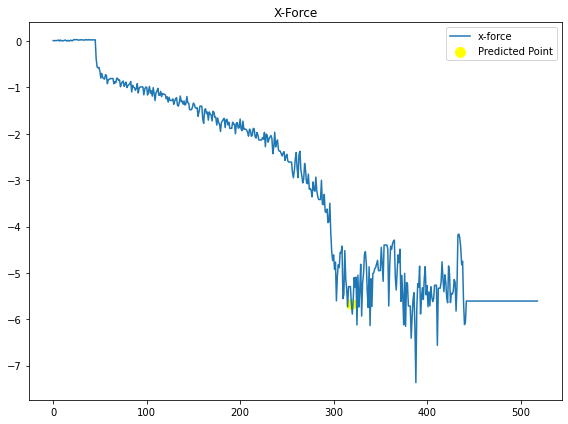

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 5.0, TRIAL_ID: 4.0


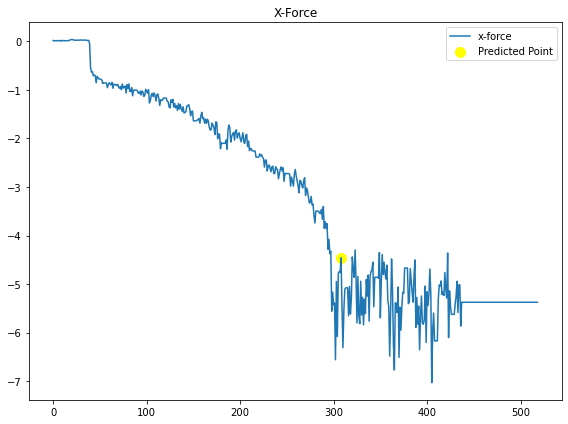

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 5.0, TRIAL_ID: 3.0


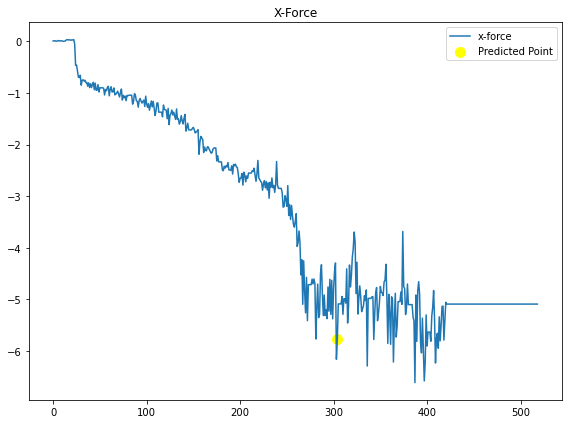

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 5.0, TRIAL_ID: 2.0


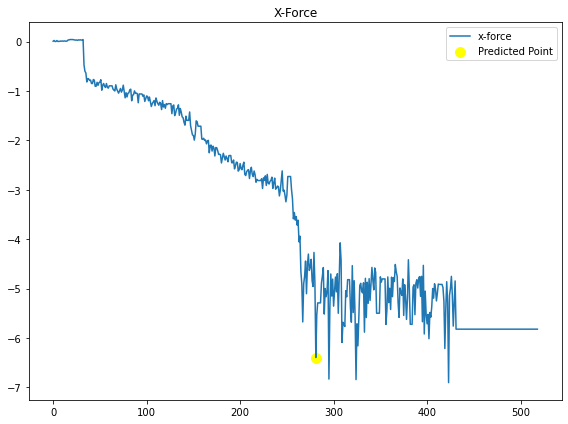

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 5.0, TRIAL_ID: 1.0


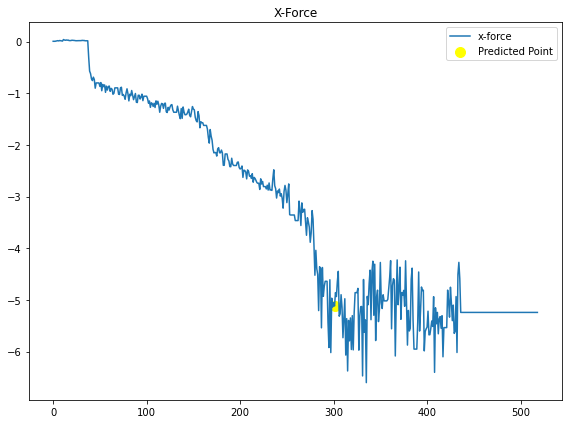

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 5.0, TRIAL_ID: 0.0


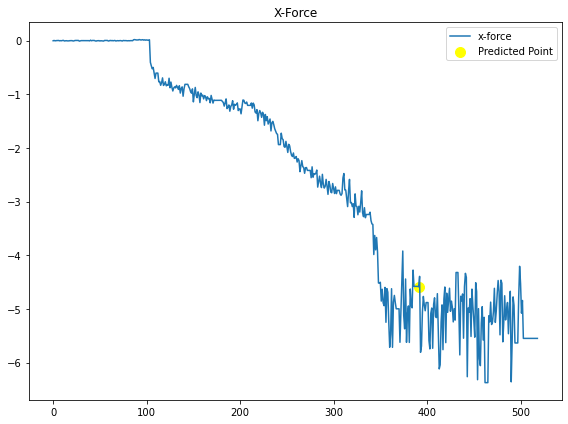

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 1.0, TRIAL_ID: 9.0


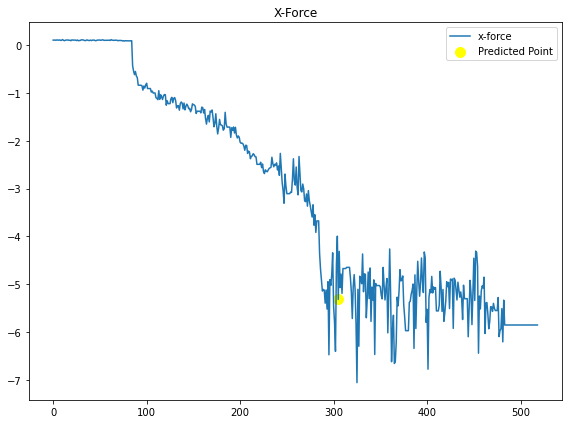

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 1.0, TRIAL_ID: 8.0


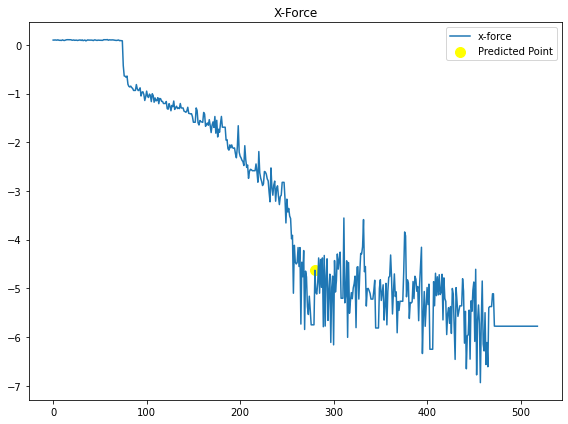

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 1.0, TRIAL_ID: 7.0


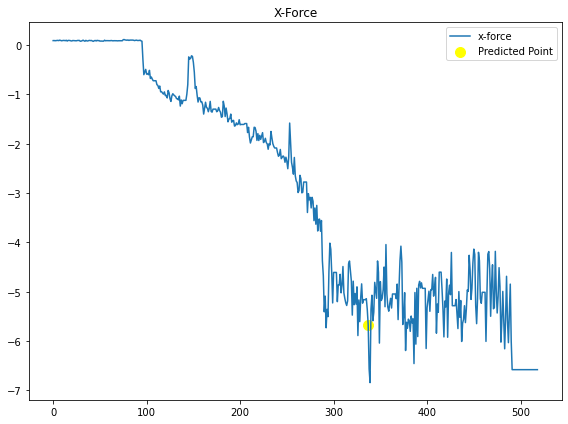

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 1.0, TRIAL_ID: 6.0


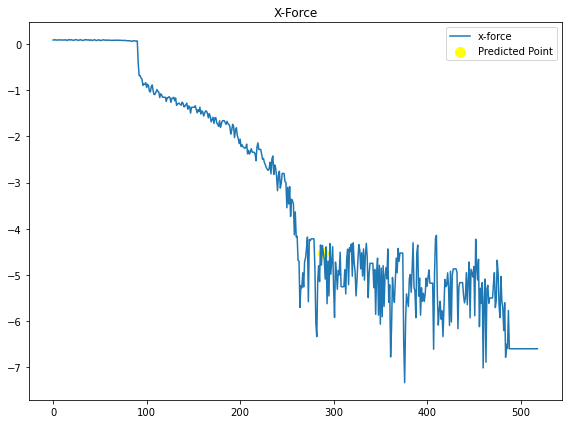

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 1.0, TRIAL_ID: 5.0


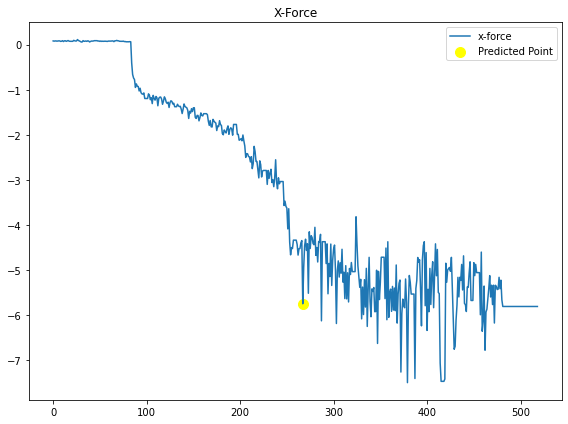

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 1.0, TRIAL_ID: 4.0


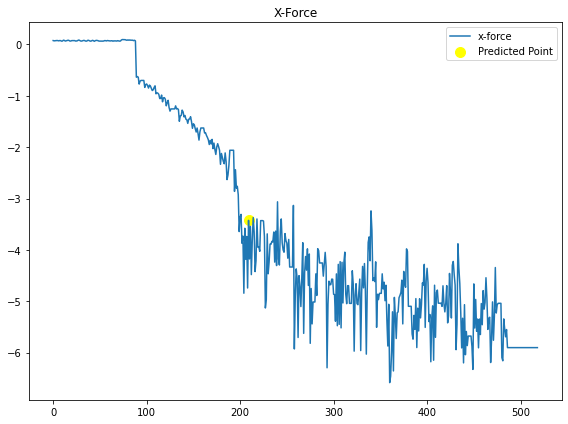

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 1.0, TRIAL_ID: 3.0


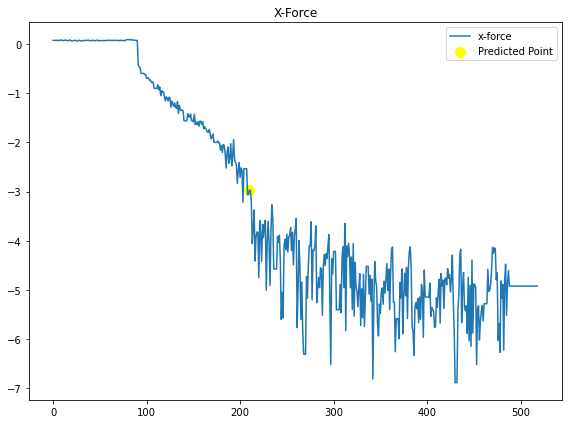

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 1.0, TRIAL_ID: 2.0


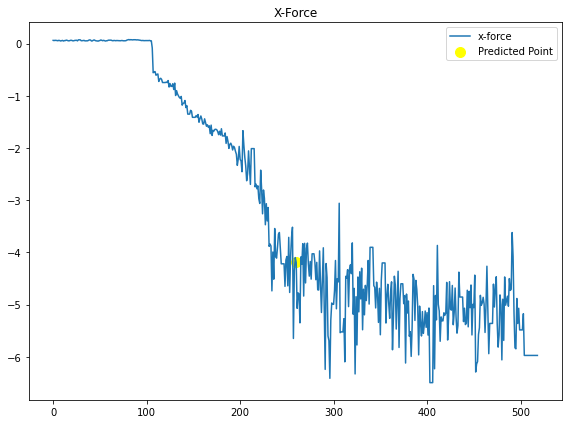

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 1.0, TRIAL_ID: 1.0


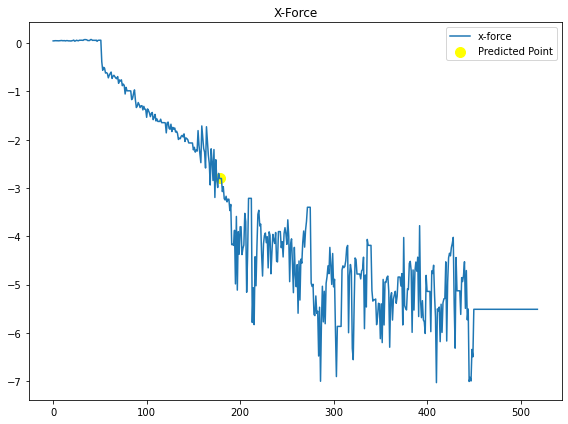

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 1.0, TRIAL_ID: 0.0


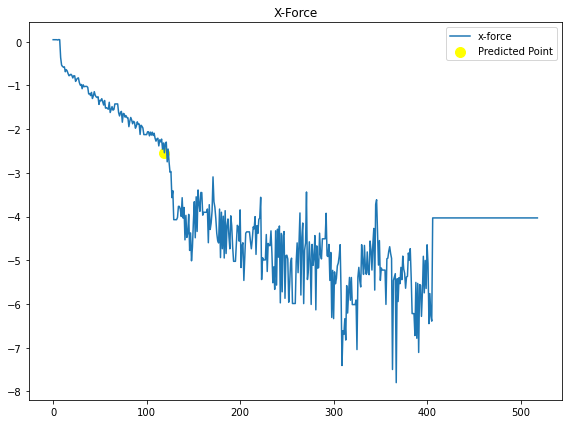

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 3.0, TRIAL_ID: 9.0


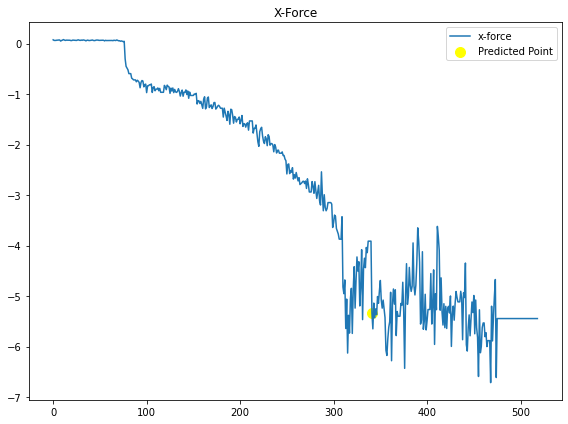

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 3.0, TRIAL_ID: 8.0


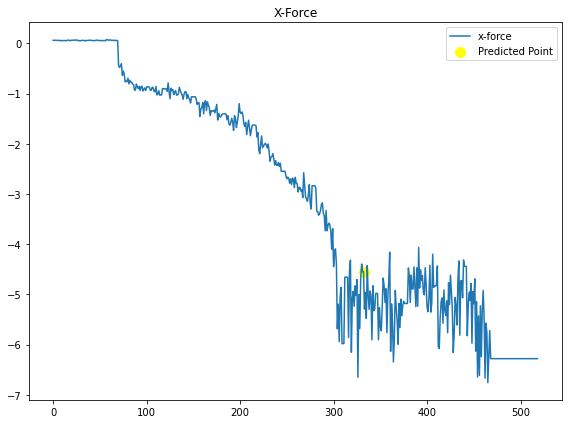

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 3.0, TRIAL_ID: 7.0


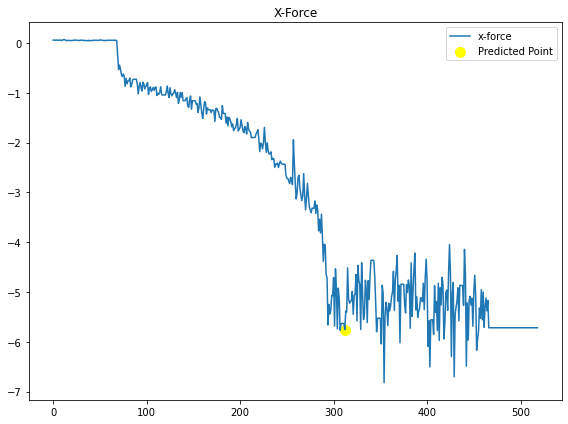

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 3.0, TRIAL_ID: 6.0


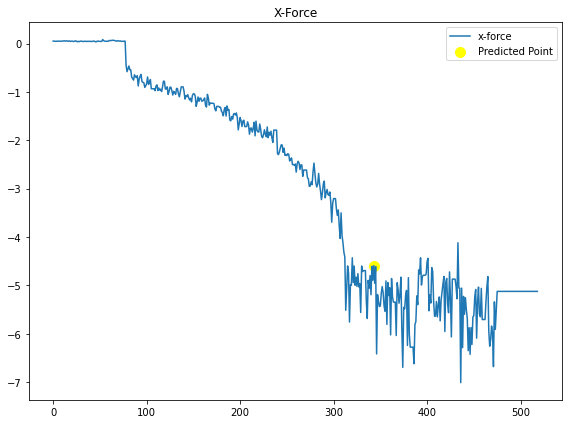

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 3.0, TRIAL_ID: 5.0


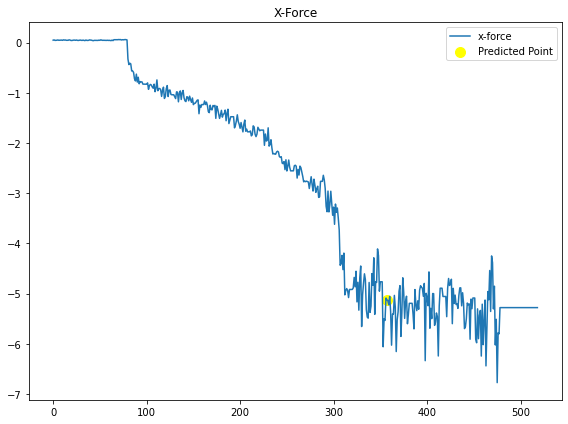

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 3.0, TRIAL_ID: 4.0


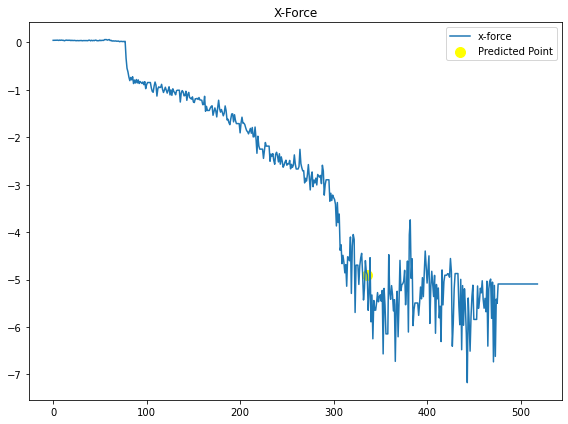

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 3.0, TRIAL_ID: 3.0


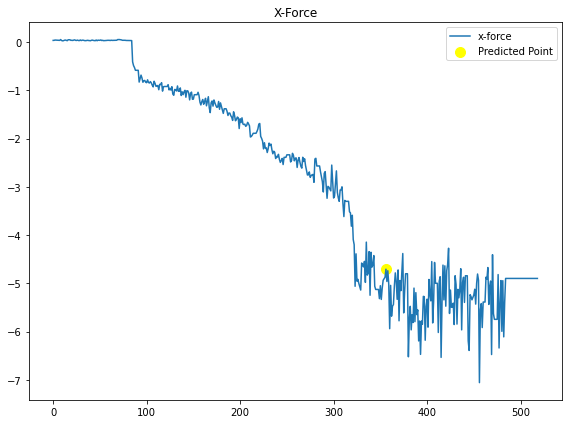

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 3.0, TRIAL_ID: 2.0


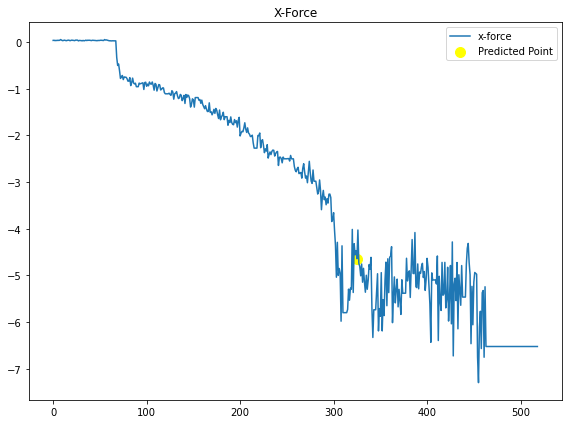

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 3.0, TRIAL_ID: 1.0


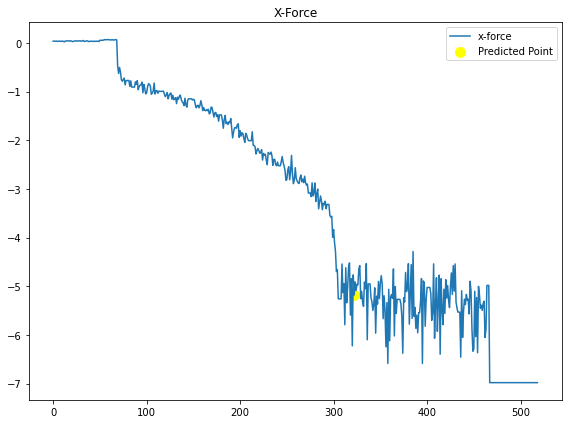

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 3.0, TRIAL_ID: 0.0


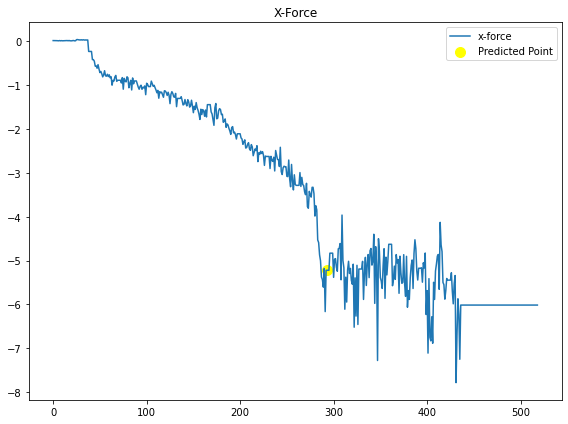

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 2.0, TRIAL_ID: 9.0


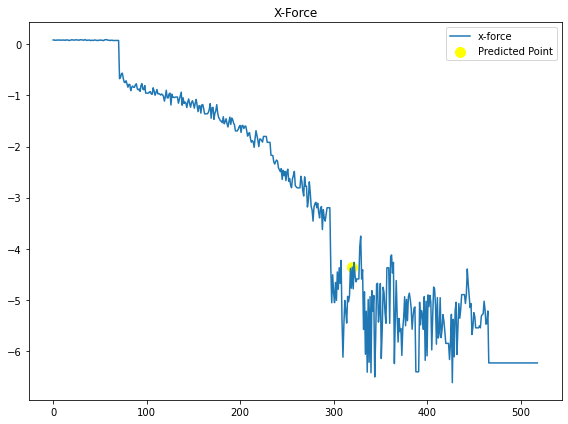

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 2.0, TRIAL_ID: 8.0


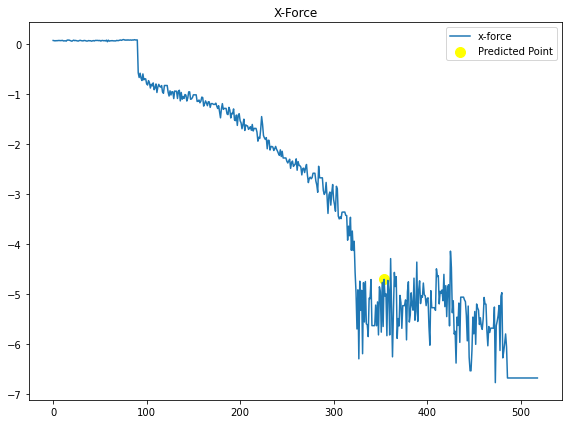

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 2.0, TRIAL_ID: 7.0


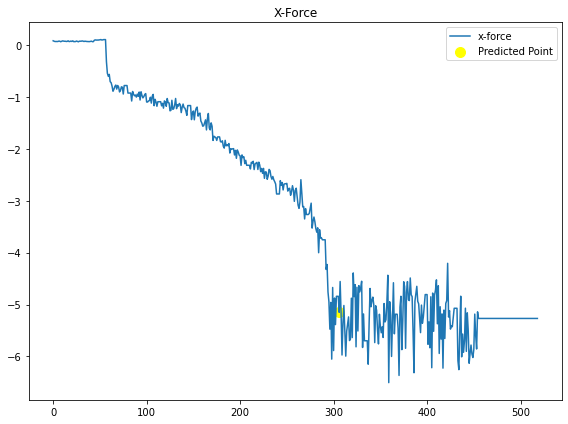

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 2.0, TRIAL_ID: 6.0


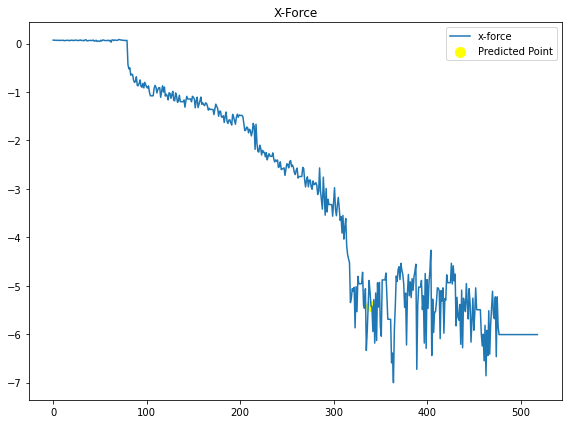

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 2.0, TRIAL_ID: 5.0


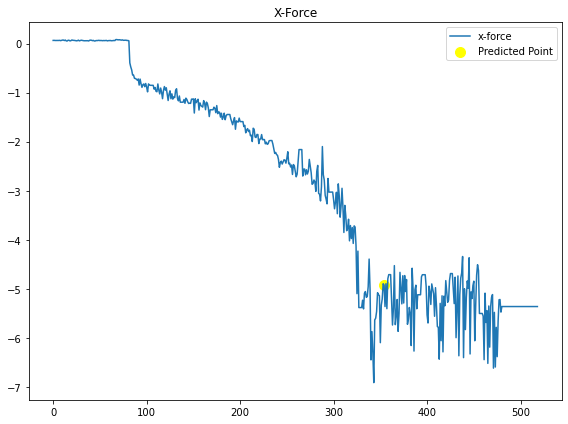

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 2.0, TRIAL_ID: 4.0


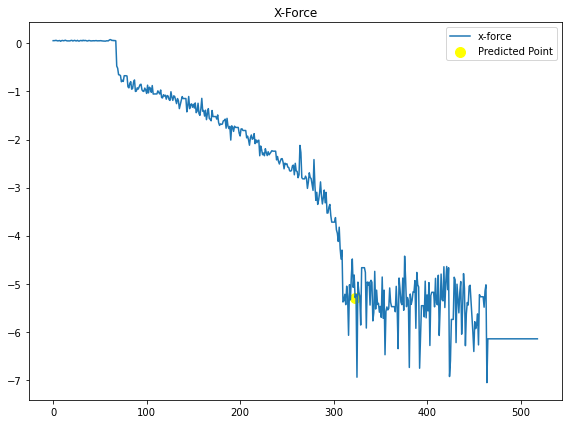

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 2.0, TRIAL_ID: 3.0


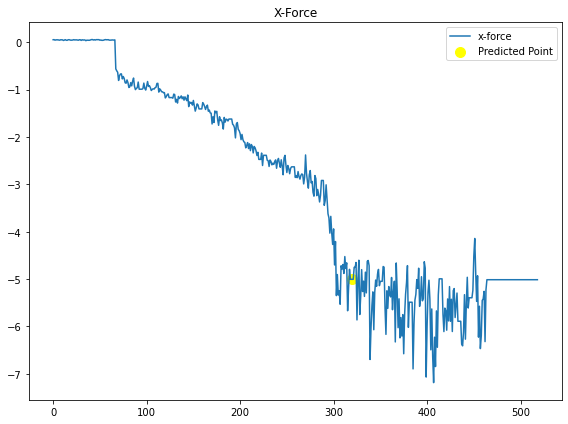

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 2.0, TRIAL_ID: 2.0


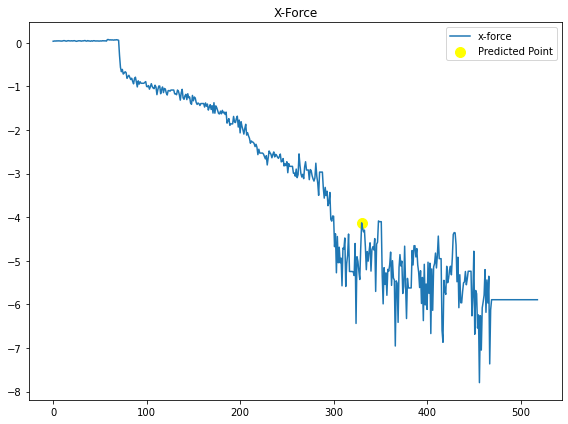

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 2.0, TRIAL_ID: 1.0


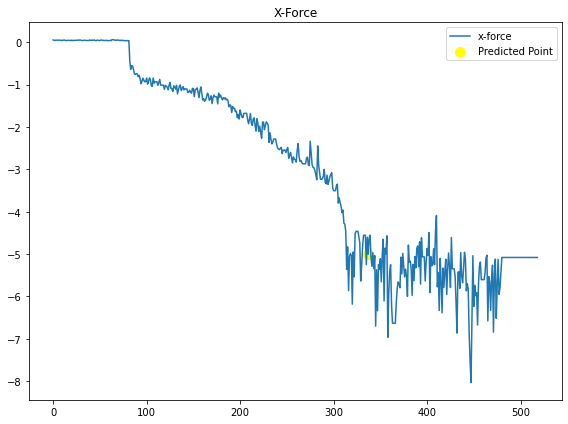

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 2.0, TRIAL_ID: 0.0


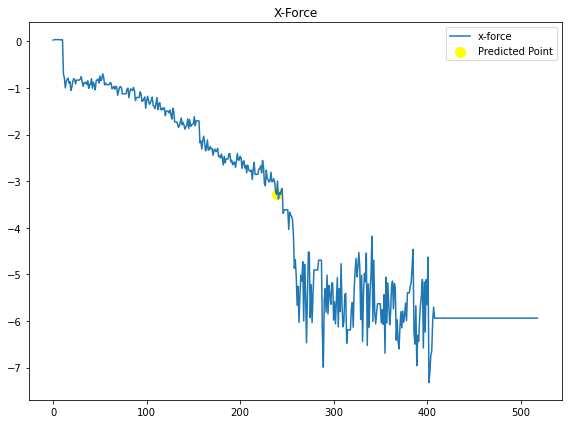

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 4.0, TRIAL_ID: 9.0


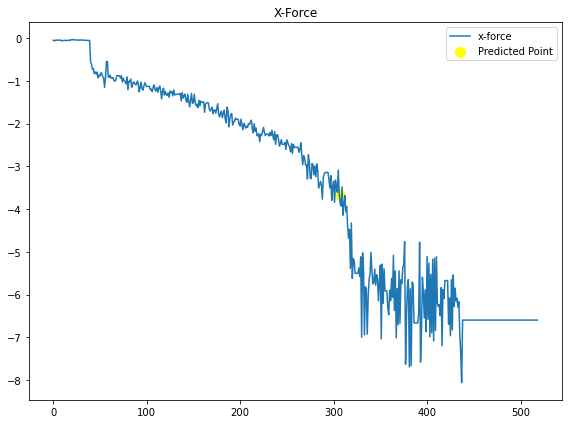

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 4.0, TRIAL_ID: 8.0


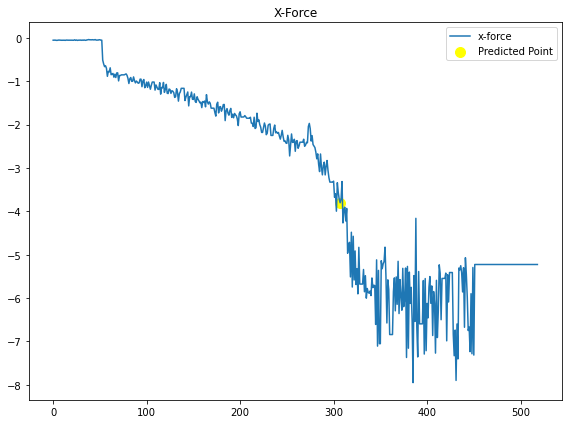

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 4.0, TRIAL_ID: 7.0


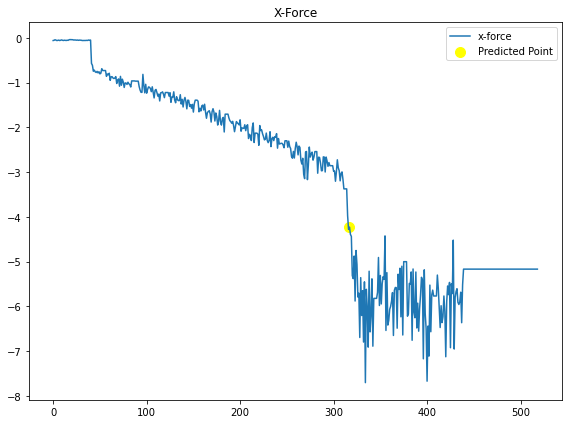

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 4.0, TRIAL_ID: 6.0


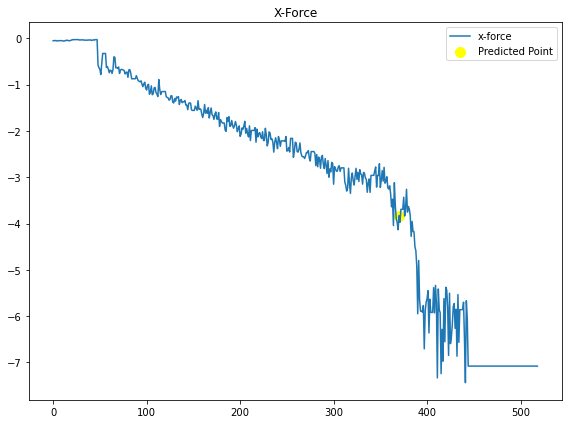

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 4.0, TRIAL_ID: 5.0


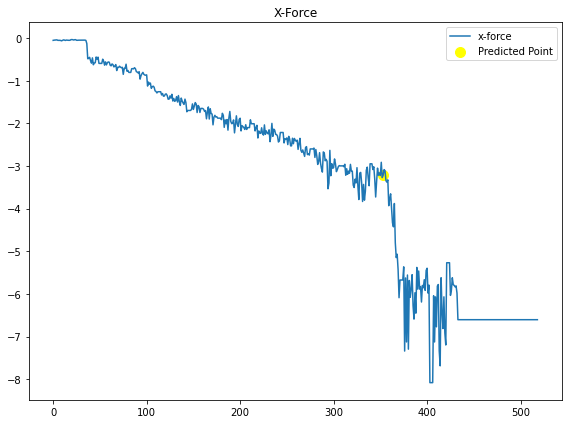

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 4.0, TRIAL_ID: 4.0


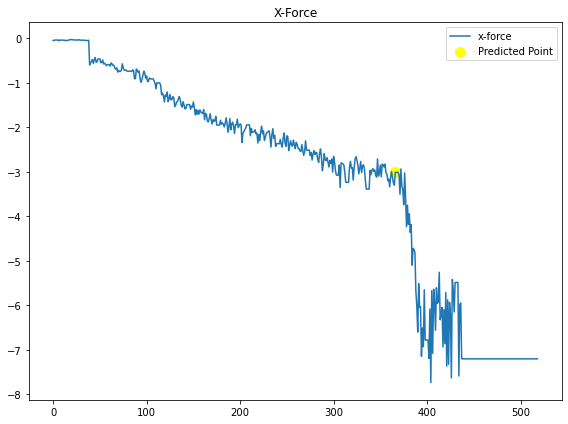

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 4.0, TRIAL_ID: 3.0


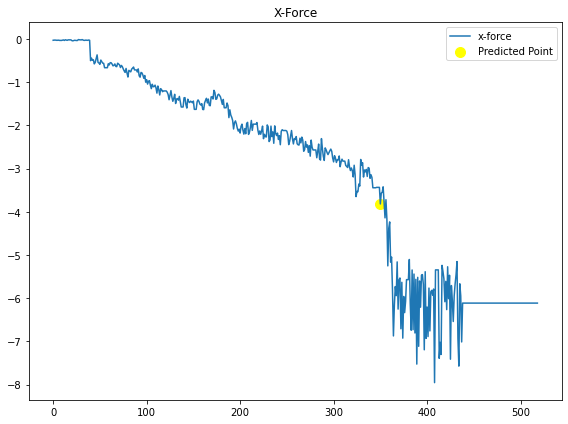

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 4.0, TRIAL_ID: 2.0


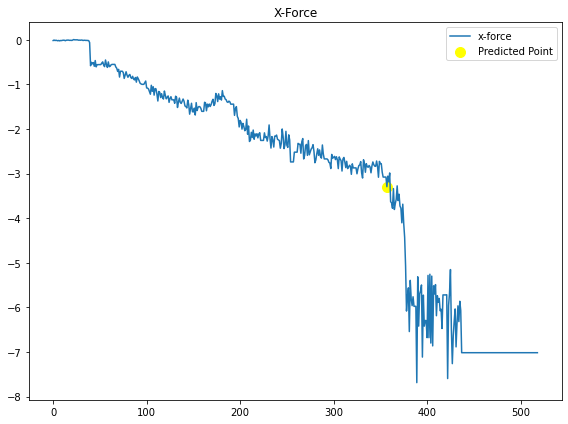

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 4.0, TRIAL_ID: 1.0


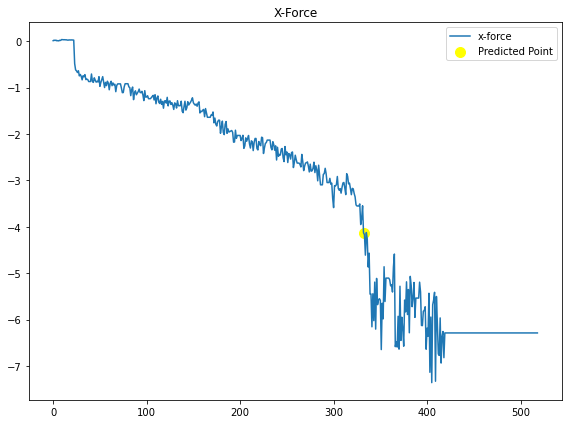

##################### NEXT #####################
RUN_ID: 794.0, EXP_ID: 4.0, TRIAL_ID: 0.0


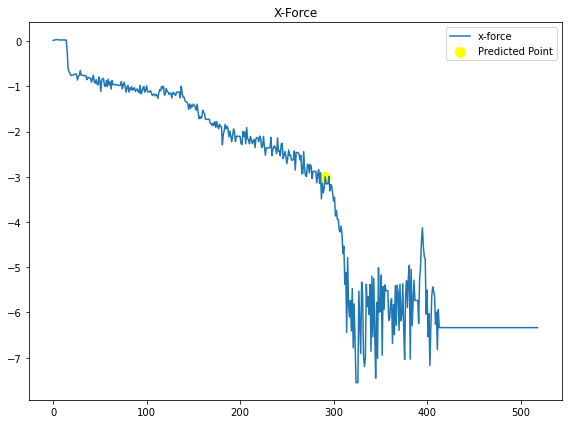

##################### NEXT #####################


In [12]:
for i, item in enumerate(preds):
    x_force = positive_examples[i]
    ids = positive_ids[:, 0, :][i]
    print(f"RUN_ID: {ids[0]}, EXP_ID: {ids[1]}, TRIAL_ID: {ids[2]}")
    item = int(item[0])

    plt.figure(figsize=(8, 6))
    
    plt.plot(np.arange(len(x_force)), x_force, label='x-force')
    #plt.scatter(label, x_force[label], color='red', label='Labeled Point', s=100)
    plt.scatter(item, x_force[item], color='yellow', label='Predicted Point', s=100)
    plt.title('X-Force')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    print("##################### NEXT #####################")

In [13]:
# Create a dictionary to store data grouped by experiment_id
grouped_data = {}

for i, item in enumerate(preds):
    x_force = positive_examples[i]
    ids = positive_ids[:, 0, :][i]
    run_id, exp_id, trial_id = ids

    # Check if the key exists in the dictionary, if not, create it
    if exp_id not in grouped_data:
        grouped_data[exp_id] = {'predicted_points': []}

    item = int(item[0])

    # Append data to the dictionary
    grouped_data[exp_id]['predicted_points'].append(item)

# Sort the grouped_data by experiment ID
grouped_data = dict(sorted(grouped_data.items()))

grouped_data[12] = {'predicted_points': [519]}

# Print out the contents of sorted grouped_data
for exp_id, data in grouped_data.items():
    print(f"Experiment ID: {exp_id}, Predicted Points: {data['predicted_points']}, Average: {np.round(np.mean(data['predicted_points']))} , STD: {np.round(np.std(data['predicted_points']))} ")

Experiment ID: 1.0, Predicted Points: [305, 280, 337, 289, 267, 209, 210, 260, 178, 119], Average: 245.0 , STD: 62.0 
Experiment ID: 2.0, Predicted Points: [320, 354, 306, 340, 354, 323, 320, 330, 337, 239], Average: 322.0 , STD: 31.0 
Experiment ID: 3.0, Predicted Points: [341, 332, 312, 343, 357, 336, 356, 325, 322, 293], Average: 332.0 , STD: 19.0 
Experiment ID: 4.0, Predicted Points: [306, 307, 317, 370, 353, 366, 350, 357, 332, 291], Average: 335.0 , STD: 27.0 
Experiment ID: 5.0, Predicted Points: [274, 278, 317, 323, 319, 308, 304, 281, 301, 391], Average: 310.0 , STD: 32.0 
Experiment ID: 6.0, Predicted Points: [258, 267, 312, 309, 307, 302, 337, 320, 404, 355], Average: 317.0 , STD: 40.0 
Experiment ID: 7.0, Predicted Points: [271, 276, 269, 325, 357, 351, 327, 301, 368, 322], Average: 317.0 , STD: 34.0 
Experiment ID: 8.0, Predicted Points: [271, 253, 293, 262, 269, 322, 281, 327, 293, 345], Average: 292.0 , STD: 29.0 
Experiment ID: 9.0, Predicted Points: [300, 363, 349, 37

In [14]:
#grouped_data['12']={'predicted_points': []}
#grouped_data

In [15]:
labels = pd.read_csv('./labels_301023.csv')
labels = labels[labels['row'] != 'None']
labels = labels[labels['row'] != 'Aussortieren']
print(len(labels))

# Create a dictionary to store data grouped by experiment_id
grouped_data_label = {}

for i, reihe in labels.iterrows():
    exp_id = reihe["experiment_id"]
    
    if exp_id not in grouped_data_label:
        grouped_data_label[exp_id] = {'predicted_points': []}

    y = reihe["row"]
    grouped_data_label[exp_id]['predicted_points'].append(y)

grouped_data_label[12] = {'predicted_points': [519]}
grouped_data_label

93


{11: {'predicted_points': ['438']},
 10: {'predicted_points': ['385', '401']},
 9: {'predicted_points': ['301',
   '337',
   '339',
   '376',
   '340',
   '352',
   '349',
   '365',
   '289',
   '324']},
 8: {'predicted_points': ['245',
   '251',
   '282',
   '272',
   '270',
   '311',
   '289',
   '313',
   '290',
   '358']},
 7: {'predicted_points': ['249',
   '270',
   '273',
   '320',
   '342',
   '354',
   '318',
   '296',
   '372',
   '312']},
 6: {'predicted_points': ['246',
   '239',
   '263',
   '251',
   '246',
   '244',
   '283',
   '281',
   '369',
   '305']},
 5: {'predicted_points': ['271',
   '275',
   '294',
   '288',
   '290',
   '287',
   '260',
   '254',
   '277',
   '338']},
 1: {'predicted_points': ['273',
   '247',
   '282',
   '253',
   '238',
   '195',
   '207',
   '222',
   '159',
   '121']},
 3: {'predicted_points': ['302',
   '292',
   '283',
   '305',
   '304',
   '304',
   '316',
   '297',
   '295',
   '278']},
 2: {'predicted_points': ['296',
   '314',
   

In [17]:
import json
# Read the JSON file
with open("794.json", 'r', encoding='utf-8') as json_file:
    # Load the JSON data into a Python dictionary
    run_statistics_794 = json.load(json_file)
# Read the JSON file
with open("795.json", 'r', encoding='utf-8') as json_file:
    # Load the JSON data into a Python dictionary
    run_statistics_795 = json.load(json_file)

    
# Assuming json_data contains the loaded JSON data
# If not, replace it with the actual variable containing the JSON data

# Label to search for
target_label = 'mipa HS 25 2K-HS-Härter'

# List to store dispensed amounts
crosslinker = []

# Find the 'result' key in the JSON data
if 'result' in run_statistics_794:
    for experiment in run_statistics_794['result']:
        if 'experiments' in experiment:
            for trial in experiment['experiments']:
                if 'trials' in trial:
                    for dispense in trial['trials']:
                        if 'nodes' in dispense:
                            for node in dispense['nodes']:
                                if 'assemblies' in node:
                                    for assembly in node['assemblies']:
                                        if 'dispensedProducts' in assembly:
                                            for dispensedProduct in assembly['dispensedProducts']:
                                                if dispensedProduct['label'] == target_label:
                                                    crosslinker.append(assembly["dispensedAmount"])
                                
# Find the 'result' key in the JSON data
if 'result' in run_statistics_795:
    for experiment in run_statistics_795['result']:
        if 'experiments' in experiment:
            for trial in experiment['experiments']:
                if 'trials' in trial:
                    for dispense in trial['trials']:
                        if 'nodes' in dispense:
                            for node in dispense['nodes']:
                                if 'assemblies' in node:
                                    for assembly in node['assemblies']:
                                        if 'dispensedProducts' in assembly:
                                            for dispensedProduct in assembly['dispensedProducts']:
                                                if dispensedProduct['label'] == target_label:
                                                    crosslinker.append(assembly["dispensedAmount"])
                                                                                              



# Remove duplicates by converting the list to a set
crosslinker = sorted(list(set(crosslinker)))
print(len(crosslinker))
crosslinker

12


[17.052999999999997,
 19.037,
 20.97,
 22.033,
 22.966,
 24.025000000000002,
 24.994,
 26.06,
 26.967000000000002,
 28.977,
 31.002,
 33.074]

In [23]:
crosslinker = (np.array(crosslinker) / 50) * 100

Bindemittel 50 g

In [24]:
exp_ids

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12]

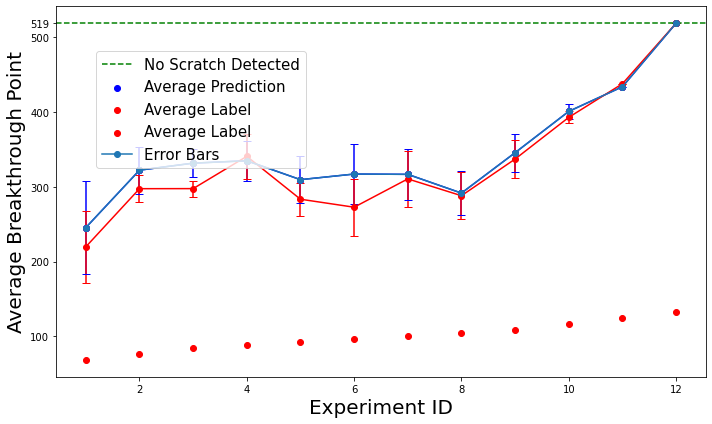

In [25]:
# Calculate average and standard deviation for each experiment
averages = {}
std_devs = {}

for exp_id, data in sorted(grouped_data.items()):
    items = np.array(data['predicted_points'])
    avg_value = np.mean(items)
    std_value = np.std(items)
    averages[exp_id] = avg_value
    std_devs[exp_id] = std_value
#################################
# Calculate average and standard deviation for each experiment in grouped_data_label
averages_label = {}
std_devs_label = {}

for exp_id, data_label in sorted(grouped_data_label.items()):
    items_label = np.array(data_label['predicted_points']).astype(float)  # Convert to numeric
    avg_value_label = np.mean(items_label)
    std_value_label = np.std(items_label)
    averages_label[exp_id] = avg_value_label
    std_devs_label[exp_id] = std_value_label
##################################
# Plot the average and standard deviation
exp_ids = list(averages.keys())
avg_values = list(averages.values())
std_values = list(std_devs.values())
##################################
# Plot the average and standard deviation
exp_ids_label = list(averages_label.keys())
avg_values_label = list(averages_label.values())
std_values_label = list(std_devs_label.values())
#################################

plt.figure(figsize=(10, 6))
#################################
plt.errorbar(exp_ids, avg_values, yerr=std_values, fmt='o-', ecolor='blue', color='blue', capsize=4)
plt.scatter(exp_ids, avg_values, color='blue', marker='o', label='Average Prediction')
#################################
plt.errorbar(exp_ids_label, avg_values_label, yerr=std_values_label, fmt='o-', ecolor='red', color='red', capsize=4)
plt.scatter(exp_ids_label, avg_values, color='red', marker='o', label='Average Label')

plt.scatter(exp_ids_label, crosslinker, color='red', marker='o', label='Average Label')

plt.axhline(y=519, color='green', linestyle='--', label='No Scratch Detected')
plt.yticks(list(plt.yticks()[0]) + [519])

plt.xlabel('Experiment ID', fontsize=20)
plt.ylabel('Average Breakthrough Point', fontsize=20)

# Create a plot with an empty error bar for the legend
plt.errorbar(exp_ids, avg_values,  fmt='o-', ecolor='grey',  label="Error Bars")
plt.legend(fontsize=15, loc='upper left', bbox_to_anchor=(0.05, 0.9),)


plt.tight_layout()

# Save the plot in high resolution and quality to a PNG file
plt.savefig('average_plot.png', dpi=300, bbox_inches='tight')
plt.show()



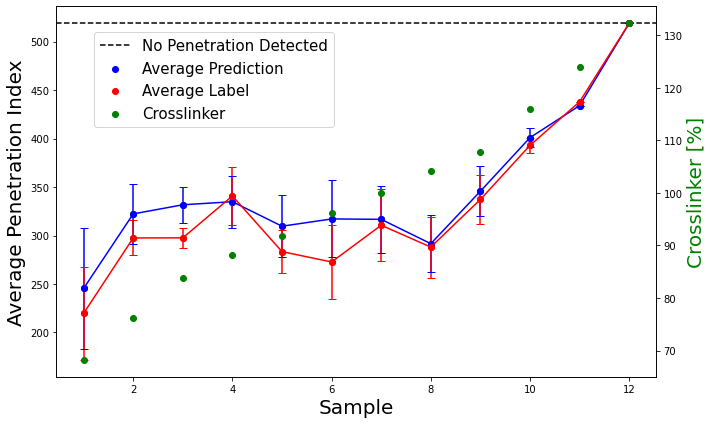

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# Your existing code...

# Calculate average and standard deviation for each experiment
averages = {}
std_devs = {}

for exp_id, data in sorted(grouped_data.items()):
    items = np.array(data['predicted_points'])
    avg_value = np.mean(items)
    std_value = np.std(items)
    averages[exp_id] = avg_value
    std_devs[exp_id] = std_value

# Calculate average and standard deviation for each experiment in grouped_data_label
averages_label = {}
std_devs_label = {}

for exp_id, data_label in sorted(grouped_data_label.items()):
    items_label = np.array(data_label['predicted_points']).astype(float)  # Convert to numeric
    avg_value_label = np.mean(items_label)
    std_value_label = np.std(items_label)
    averages_label[exp_id] = avg_value_label
    std_devs_label[exp_id] = std_value_label

# Plot the average and standard deviation
exp_ids = list(averages.keys())
avg_values = list(averages.values())
std_values = list(std_devs.values())

# Plot the average and standard deviation
exp_ids_label = list(averages_label.keys())
avg_values_label = list(averages_label.values())
std_values_label = list(std_devs_label.values())

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis (left) 
ax1.errorbar(exp_ids, avg_values, yerr=std_values, fmt='o-', ecolor='blue',color='blue', capsize=4)
ax1.scatter(exp_ids, avg_values, color='blue', marker='o', label='Average Prediction')
ax1.errorbar(exp_ids_label, avg_values_label, yerr=std_values_label, fmt='o-', ecolor='red', color='red', capsize=4)
ax1.scatter(exp_ids_label, avg_values_label, color='red', marker='o', label='Average Label')

# Secondary y-axis (right) for crosslinker
ax2 = ax1.twinx()
ax2.scatter(exp_ids_label, crosslinker, color='green', marker='o', label='Crosslinker')
ax2.set_ylabel('Crosslinker [%]', color='green', fontsize=20)

# Common x-axis settings
ax1.set_xlabel('Sample', fontsize=20)
ax1.set_ylabel('Average Penetration Index', fontsize=20)
ax1.axhline(y=519, color='black', linestyle='--', label='No Penetration Detected')
#ax1.yticks(list(ax1.get_yticks()) + [519])

# Create a plot with an empty error bar for the legend
#ax1.errorbar(exp_ids, avg_values, fmt='o-', ecolor='grey', label="Error Bars")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.05, 0.95), fontsize=15)

# Adjust layout
fig.tight_layout()

# Save the plot in high resolution and quality to a PNG file
plt.savefig('average_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
import plotly.graph_objects as go
import plotly.io as pio

# Assuming 'grouped_data' is defined

# Calculate average and standard deviation for each experiment
averages = {}
std_devs = {}

for exp_id, data in sorted(grouped_data.items()):
    items = np.array(data['predicted_points'])
    avg_value = np.mean(items)
    std_value = np.std(items)
    averages[exp_id] = avg_value
    std_devs[exp_id] = std_value

# Create a Plotly figure
fig = go.Figure()

# Plot the average and standard deviation with lines+markers
exp_ids = list(averages.keys())
avg_values = list(averages.values())
std_values = list(std_devs.values())

fig.add_trace(go.Scatter(
    x=exp_ids,
    y=avg_values,
    mode='lines+markers',
    line=dict(color='blue'),
    error_y=dict(type='data', array=std_values, visible=True),
    name='Average with Std Dev'
))

# Update layout to increase font size of axis labels
fig.update_layout(
    title='Average and Std Dev across Experiments',
    xaxis=dict(title='Experiment ID', tickmode='linear'),
    yaxis=dict(title='Average Predicted Point'),
    font=dict(size=30),
    width=1400,  # Decrease width
    height=900  # Decrease height# Increase font size
)

# Save the plot to an HTML file
pio.write_html(fig, file='average_plot_plotly.html')